How to run a simple N-body code
====================

Here we will generate initial conditions for an N-body code, run a small simulation and analyse the results. This analysis is performed on a 100 star cluster in a 1 pc virial-radius King model. Stellar masses are taken randomly from a Salpeter distribution.
Stellar evolution is ignored in this simulation.

For reference you can read chapter 2 of Portegies Zwart & McMillan 2018 (2018araa.book.....P). 

With this tutorial you will learn
- how to generate initial conditions (mass function, King-model)
- to initialize a gravitational N-body code
- channels and intra-code data transfer
- detecting binaries
- plotting results
- making cumulative distributions

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from amuse.units import units

We start by setting-up a simulation by specifying a stellar mass distribution

In [2]:
n_stars = 100
alpha_IMF = -2.35

from amuse.lab import new_powerlaw_mass_distribution
m_stars = new_powerlaw_mass_distribution(n_stars, 0.1|units.MSun, 
                                        100|units.MSun, alpha_IMF)

Now check to see if this indeed gives one the expected mass function by plotting the cumulative distribution against a theoretical distribution.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


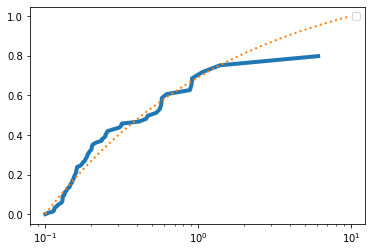

In [4]:
def plot_cdf(m, alpha_IMF=-2.35):
    m = sorted(m.value_in(units.MSun))
    fm = numpy.array([0])
    for mi in m:
        fm = numpy.append(fm, fm[-1] + mi)
    fm /= max(fm)
    from amuse.plot import plot
    pyplot.plot(m, fm[:len(m)], lw=4, ls="-",label = 'cumulative')
    x = 10**numpy.arange(-1.0, 1.0, 1./len(m))
    y = x**(alpha_IMF+2)
    fy = numpy.array([0])
    for yi in y:
        fy = numpy.append(fy, fy[-1] + yi)    
    fy /= max(fy)
    pyplot.plot(x, fy[:len(x)], lw=2, ls=":", label = 'theory')
    pyplot.semilogx()
    pyplot.show()
pyplot.legend()
plot_cdf(m_stars)

### Question:
Can you explain why the dotted curve does not overplot with the solid curve?

Now we can initialize the cluster size and declare the converter.

### Converter
N-body codes operate using special dimensionless N-body units (where the gravitational constant is set to unity). In order to make the code understand SI units, we must pass it a unit converter. This contains two quantities in the relevant unit system, from which AMUSE derives the proper unit conversion. Best practice is to keep those quantities on the order of the system's scale (e.g. the total mass and the radius of the outermost planet in a planetary system) to ensure numerical stability.

Also see the documentation on the importance of [converters](https://amuse.readthedocs.io/en/latest/reference/quantities_and_units.html?highlight=generic%20units#module-amuse.units.generic_unit_system) in AMUSE. 


In [ ]:
r_cluster = 1.0 | units.parsec
from amuse.units import nbody_system
converter=nbody_system.nbody_to_si(m_stars.sum(),r_cluster)
from amuse.ic.kingmodel import new_king_model
W0 = 3.0
bodies=new_king_model(n_stars, W0, convert_nbody=converter)
bodies.scale_to_standard(converter)

Check the result by plotting the X-Y positions of the bodies.

In [ ]:
from amuse.plot import scatter
def plot_snapshot(bodies):
    v = (bodies.vx**2 + bodies.vy**2 + bodies.vz**2).sqrt()
    scatter(bodies.x, bodies.y, c=v.value_in(units.kms), alpha=0.5)
    pyplot.colorbar()
    pyplot.show()
plot_snapshot(bodies)

In [ ]:
from amuse.community.ph4.interface import ph4
from amuse.ext.LagrangianRadii import LagrangianRadii

gravity = ph4(converter)
gravity.particles.add_particles(bodies)
# A channel is a 'permanent' connection to a code's particle
# set. Multiple calls to a code's particle set need to set up
# a new connection every time; with a channel, we can copy
# information back without opening a new connection.
# This does not automatically update bodies! See below
channel = gravity.particles.new_channel_to(bodies)


times = numpy.arange(0, 100, 0.1) | units.Myr
RL25 = [] | units.parsec
Rvir = [] | units.parsec
for time in times:
    gravity.evolve_model(time)
    channel.copy() # Copy from gravity.particles to bodies
    Rvir.append(bodies.virial_radius())
    L = LagrangianRadii(bodies)
    RL25.append(LagrangianRadii(bodies)[5])

    if not time.value_in(units.Myr)%10.0:
        print("cluster at Time=", time.in_(units.Myr), 
              "Mass=", bodies.mass.sum().in_(units.MSun),
              "Rvir=", Rvir[-1].in_(units.parsec))
    b = bodies.get_binaries()
    if(len(b)>0):
        print("Number of binaries found:", len(b))
        print("first binary:", b[0])

pyplot.plot(times.value_in(units.Myr), RL25.value_in(units.parsec))
pyplot.plot(times.value_in(units.Myr), Rvir.value_in(units.parsec))
pyplot.show()

You have now calculated the dynamical evolution of a small cluster of stars including a realistic mass function.

Assignments and questions:
---------------

### Question 1:
Why do we have to *scale_to_standard()* after assigning the masses and positions to all the particles?

### Question 2:
Run the notebook and describe the evolution of the virial radius.

### Assignment 2:
There is a check for binary detection in the script.
If no binary formed in your run, that is okay.

Run the script again until a binary forms.

### Question 3:
One of the parameters in the binary is the *hardness*.
What is the hardness of the binary from your last run? and explain what is meant with this parameter.

### Assignment 3:
Rewrite the script in such a way that the event loop over time continues indefinitely, but that the code stops as soon as the first binary is detected.

Run the script several times until you have enough first binaries formed to make a histogram of the first-binary formation time-scale.

Now, make a small change to your initial conditions.
A variation could include the dimensionless depth of the potential of the initial King model, the slope of the initial-mass function, its lower limit, or the number of stars in the simulation).

Now redo the calculation in which you generate a histogram of moments of first-binary formation.

Make one figure with both distributions: the original distribution for first-binary formation time and the second series of runs (with the altered initial conditions.
Present both distributions as histograms and as cumulative distributions. 

### Question 4:
Can you understand the difference in first-binary formation-time based on the changes you introduced in the initial conditions?

Did you perform enough runs to make a statistically significant statement about the time of first-binary formation?

### Assignment 4:
Make a cumulative distribution of the masses of the two stars for each first binary and compare it to the initial mass-function.

### Question 5:
Can you understand the difference between the typical masses of the binaries that formed first and the initial mass-function?